# Introduction

In this project we show different architectures for deep learning that will help us classify satellite images. In our first part of the project we show how to preprocess the data, tackle data imbalance, and use two common techniques in deep learning to train our model (transfered learning and feature extraction).

# Setting up the Google Collab Environment

We use the following dependenicies in our code:
1. Pytorch: For implementing deep learning solutions.
2. Matplotlib: For data visualiztion
3. CV2: For visualizing images
4. Sklearn: For machine learning solutions
5. Numpy: For matrix manipulations

**Importing Libraries**

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists

cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

print("Accelerator type = ",accelerator)
print("Pytorch verision: ", torch.__version__)

('Accelerator type = ', 'cu100')
('Pytorch verision: ', '1.0.1.post2')


**Importing the data**

Google Collab is an exciting addition to the Machine Learning community. Using google collab, anyone can use GPUs to train their model. What we do here is is mount our google drive into our collab environment so that we can access all of our folder.

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Check if the data has been loaded to the Google Collab Environment**

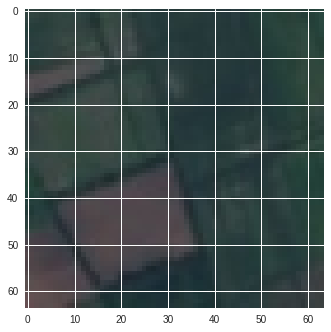

In [0]:
a = cv2.imread("/content/drive/My Drive/ComputerVision/Test/data/test/1/31.jpg")
a = a[...,::-1]
plt.imshow(a)
plt.show()

# Setting Up Pytorch Environment

We need to proprocess the image before passing it throught the model for training. These are the preprocessing steps:
1. *Resize:* The resnet requires an input image size to be (224, 224) so we first rescale the image. 
2. *Convert to Tensor*: The Pytorch uses a data class called Tensor. We have to convert from our numpy array to this data type.
3. *Batch Normalize:* Since we will be using batch stochastic gradient descent (the computer memory can't load the entire dataset in one instance), we need to normalize all imagize based on the mean and standard deviation across the batch to [0.485,0.456,0.406] and [.229, .224, .225] respectively.

In [0]:
def get_data(data_dir):

    #Pre processing the data
    normalize = transforms.Normalize(mean = [0.485,0.456,0.406],
                                    std = [0.229,0.224,0.225])
    resize = transforms.Resize((224,224))

    preprocessor = transforms.Compose([
                                        resize,
                                        transforms.ToTensor(),
                                        normalize])

    train_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(os.path.join(data_dir,'train'),preprocessor),
        batch_size=50,
        shuffle = True)

    test_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(os.path.join(data_dir,'test'),preprocessor),
        batch_size=50,
        shuffle = True)

    return train_loader, test_loader, len(os.listdir(os.path.join(data_dir,'train')))

In [0]:
trainloader, testloader, num_classes = get_data("/content/drive/My Drive/ComputerVision/OneConcern/data")
print("Number of classes:", num_classes)

('Number of classes:', 10)


**Loading the Model**

1.  *Model choice: * this iteration we use a ResNet-18 model. A ResNet model is known for it's skip connections that enables the model to learn identity functions for particular steps thus enabling a deep model to still converge.
2. *Transferred Learning: * Since we don't have the hardware capacity to train a deep model from scratch we will only train the last layer. 
3. *Loss Function: * Since it's an object classification problem, with think the cross entropy equation will serve as a good loss function. 
4. *Optimizer: * We used a stochastic gradient descent for our first iteration, but would prefer to switch to Adam Optimizer for a later iteration.

In [0]:
gpu_flag = torch.cuda.is_available()

#preloading Resnet18
model = models.resnet18(pretrained = True)

#append a new last layer
model.fc = nn.Linear(512,num_classes)

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer,5,.3)

#Pre processing the data
normalize = transforms.Normalize(mean = [0.485,0.456,0.406], std = [0.229,0.224,0.225])
resize = transforms.Resize((224,224))

preprocessor = transforms.Compose([resize,transforms.ToTensor(),normalize])


gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    
print model

True
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2

In [0]:
if gpu_flag:
  print("We have gpu!")
  model = model.cuda()
  criterion = criterion.cuda()

epochs = 10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

We have gpu!


In [0]:
train_loss = []
test_loss = []
accuracy = []

for e in range(epochs):
      exp_lr_scheduler.step()
    
      #put model in training mode
      model.train()
      avg_loss = 0

      for i, (x,y) in enumerate(trainloader):
            optimizer.zero_grad()

            if gpu_flag:
                  x_var = Variable(x).cuda()
                  y_actual = Variable(y).cuda()
            else:
                  x_var = Variable(x)
                  y_actual = Variable(y)

            y_pred = model.forward(x_var)
            loss = criterion(y_pred,y_actual)
            loss.backward()
            
            if(i%10 == 0):
                  print(i, loss.item())
            avg_loss+=loss.item()
            optimizer.step()
            
      print("Done Training")
      train_loss.append(avg_loss*1.0/(i+1))
      
      #set model in evaluation mode
      model.eval()
      avg_loss = 0
      correct_pred = 0
      total_pred = 0
      
      for i, (x_test,y_test) in enumerate(testloader):

          if gpu_flag:
              x_test_var = Variable(x_test).cuda()
              y_test_var = Variable(y_test).cuda()
          else:
              x_test_var = Variable(x_test)
              y_test_var = Variable(y_test)

          y_pred_test = model.forward(x_test_var)
          loss = criterion(y_pred_test,y_test_var)
          avg_loss+=loss.item()
          vals, y_pred = torch.max(y_pred_test,1)

          correct_pred += (y_pred.cpu().data.numpy()==y_test_var.cpu().data.numpy()).sum()
          total_pred += len(y_pred_test.cpu())
      
      test_loss.append(avg_loss*1.0/i)
      accuracy.append(correct_pred*100.0/total_pred)
      print("Epoch: ", e, "Train Loss: ", train_loss[-1], "Test Loss: ", test_loss[-1], "Accuracy: ", accuracy[-1])
      
      #replace model saved 
      if accuracy[-1]>best_acc:
          best_acc = accuracy[-1]
          best_model_wts = copy.deepcopy(model.state_dict())
          model.load_state_dict(best_model_wts)
          torch.save(model,'/content/drive/My Drive/ComputerVision/OneConcern/best_finetune.pt')
          print("Saved model with accuracy: ", best_acc)

(0, 0.02078286185860634)
(10, 0.03140169009566307)
(20, 0.046105872839689255)
(30, 0.018269214779138565)
(40, 0.07951486110687256)
(50, 0.09838642925024033)
(60, 0.1907305121421814)
(70, 0.0900983065366745)
(80, 0.055307578295469284)
(90, 0.10102881491184235)
(100, 0.13847710192203522)
(110, 0.10576970875263214)
(120, 0.07687371224164963)
(130, 0.03667012229561806)
(140, 0.10552529245615005)
(150, 0.04405132681131363)
(160, 0.09697481989860535)
(170, 0.05469506233930588)
(180, 0.02870185859501362)
(190, 0.0691099613904953)
(200, 0.07347388565540314)
(210, 0.064165860414505)
(220, 0.09556248784065247)
(230, 0.07088238000869751)
(240, 0.07585029304027557)
(250, 0.17519958317279816)
(260, 0.13710592687129974)
(270, 0.05090971291065216)
(280, 0.06478855013847351)
(290, 0.019459610804915428)
(300, 0.01304483413696289)
Done Training
('Epoch: ', 0, 'Train Loss: ', 0.07815007705687511, 'Test Loss: ', 0.10564717385530858, 'Accuracy: ', 96.7599792638673)
('Saved model with accuracy: ', 96.759979

In [0]:
list_epochs = [i+1 for i in range(10)]

plt.plot(list_epochs,accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Resnet-18 Accuracy vs. Accuracy')
plt.show()
plt.plot(list_epochs,train_loss,label='Train Loss')
plt.plot(list_epochs,test_loss,label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()

NameError: ignored